In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

ROOT_DIR = '/home/cds/govind/prj/aae_theta'
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

In [3]:
from main import train_helper
import tensorflow as tf
from smpl.smpl_layer import SmplTPoseLayer
import numpy as np
from dataset.Data_3DPW.vis import plot_3d as p3d_3dpw
from main import config as cfg
import cv2
from common import util

In [7]:
npy_data = train_helper.read_npy()
npy_data.keys()

100%|██████████| 35515/35515 [00:00<00:00, 235022.75it/s]


(3956100, 23, 1, 3)
(22735, 23, 1, 3)
(10086, 23, 1, 3)
(35515, 23, 1, 3)
(22735, 10)
(10086, 10)
(35515, 10)


['d3pw_test_beta',
 'd3pw_train_theta',
 'd3pw_validation_beta',
 'd3pw_test_theta',
 'd3pw_validation_theta',
 'd3pw_train_beta',
 'train_theta']

In [8]:
train_theta = npy_data['train_theta']
d3pw_train_theta = npy_data['d3pw_train_theta']
d3pw_validation_theta = npy_data['d3pw_validation_theta']
d3pw_test_theta = npy_data['d3pw_test_theta']

print(train_theta.shape)
print(d3pw_train_theta.shape)
print(d3pw_validation_theta.shape)
print(d3pw_test_theta.shape)

(3956100, 23, 1, 3)
(22735, 23, 1, 3)
(10086, 23, 1, 3)
(35515, 23, 1, 3)


In [2]:
# train_theta = util.rodrigues_repr(train_theta)
# d3pw_train_theta = util.rodrigues_repr(d3pw_train_theta)
# d3pw_validation_theta = util.rodrigues_repr(d3pw_validation_theta)
# d3pw_test_theta = util.rodrigues_repr(d3pw_test_theta)

# print(train_theta.shape)
# print(d3pw_train_theta.shape)
# print(d3pw_validation_theta.shape)
# print(d3pw_test_theta.shape)

In [1]:
# train_theta = np.reshape(train_theta, [-1, 23, 3, 3])
# d3pw_train_theta = np.reshape(d3pw_train_theta, [-1, 23, 3, 3])
# d3pw_validation_theta = np.reshape(d3pw_validation_theta, [-1, 23, 3, 3])
# d3pw_test_theta = np.reshape(d3pw_test_theta, [-1, 23, 3, 3])

# print(train_theta.shape)
# print(d3pw_train_theta.shape)
# print(d3pw_validation_theta.shape)
# print(d3pw_test_theta.shape)

In [10]:
# np.save('/sda5/govind/exp_aae_theta/data/train_theta_3x3.npy', train_theta)
# np.save('/sda5/govind/exp_aae_theta/data/d3pw_train_theta_3x3.npy', d3pw_train_theta)
# np.save('/sda5/govind/exp_aae_theta/data/d3pw_validation_theta_3x3.npy', d3pw_validation_theta)
# np.save('/sda5/govind/exp_aae_theta/data/d3pw_test_theta_3x3.npy', d3pw_test_theta)

In [4]:
model = train_helper.init_model()
model.theta_enc = model.encoder(model.theta_ph)
model.theta_dec = model.decoder(model.theta_emb_ph)

model.encoder_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='AAE_Encoder')
model.decoder_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='AAE_Decoder')

encoder_saver = tf.train.Saver(model.encoder_params, max_to_keep=cfg.MAX_TO_KEEP)
decoder_saver = tf.train.Saver(model.decoder_params, max_to_keep=cfg.MAX_TO_KEEP)

# SMPL
if cfg.J3D_3x1:
    smpl = SmplTPoseLayer(theta_in_rodrigues=True, theta_is_perfect_rotmtx=False)
    smpl_theta_ph = tf.placeholder(tf.float32, shape=[None, 24, 1, 3])
else:
    smpl = SmplTPoseLayer(theta_in_rodrigues=False, theta_is_perfect_rotmtx=True)
    smpl_theta_ph = tf.placeholder(tf.float32, shape=[None, 24, 3, 3])


smpl_beta_ph = tf.placeholder(tf.float32, shape=[None, 10])
cam_smpl_out = smpl([smpl_theta_ph, smpl_beta_ph, None, None])

Instructions for updating:
Colocations handled automatically by placer.


2020-07-13 01:02:12 - tensorflow[1228] WARNING From /home/cds/govind/virt_env_2.7/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use keras.layers.flatten instead.


2020-07-13 01:02:13 - tensorflow[1228] WARNING From /home/cds/govind/prj/aae_theta/main/model.py:57: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


('theta_in', TensorShape([Dimension(None), Dimension(69)]))
Instructions for updating:
Use keras.layers.dense instead.


2020-07-13 01:02:13 - tensorflow[1228] WARNING From /home/cds/govind/prj/aae_theta/main/model.py:60: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


('ENCODER_FC_1', TensorShape([Dimension(None), Dimension(1024)]))
('ENCODER_FC_2', TensorShape([Dimension(None), Dimension(1024)]))
('ENCODER_FC_3', TensorShape([Dimension(None), Dimension(512)]))
('ENCODER_Theta_Enc', TensorShape([Dimension(None), Dimension(32)]))
('DECODER_FC_1', TensorShape([Dimension(None), Dimension(512)]))
('DECODER_FC_2', TensorShape([Dimension(None), Dimension(1024)]))
('DECODER_FC_3', TensorShape([Dimension(None), Dimension(1024)]))
('DECODER_Theta_Dec', TensorShape([Dimension(None), Dimension(69)]))


In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.InteractiveSession(config=config)
session.run(tf.global_variables_initializer())

encoder_saver.restore(session, os.path.join('/sda5/govind/exp_aae_theta/aae_correct_13/model/', 'encoder-' + str(94)))
decoder_saver.restore(session, os.path.join('/sda5/govind/exp_aae_theta/aae_correct_13/model/', 'decoder-' + str(94)))

Instructions for updating:
Use standard file APIs to check for files with this prefix.


2020-07-13 01:02:17 - tensorflow[1228] WARNING From /home/cds/govind/virt_env_2.7/local/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /sda5/govind/exp_aae_theta/aae_correct_13/model/encoder-94


2020-07-13 01:02:17 - tensorflow[1228] INFO Restoring parameters from /sda5/govind/exp_aae_theta/aae_correct_13/model/encoder-94


INFO:tensorflow:Restoring parameters from /sda5/govind/exp_aae_theta/aae_correct_13/model/decoder-94


2020-07-13 01:02:17 - tensorflow[1228] INFO Restoring parameters from /sda5/govind/exp_aae_theta/aae_correct_13/model/decoder-94


In [10]:
dataset_theta = npy_data['train_theta']
dataset_theta.shape

(3956100, 23, 1, 3)

In [11]:
feed_dict = {}
idx = np.random.randint(0, dataset_theta.shape[0], 256)
theta_in_enc = dataset_theta[idx]
feed_dict[model.theta_ph] = theta_in_enc
[theta_emb] = session.run([model.theta_enc], feed_dict=feed_dict)
print(theta_emb.shape)

(256, 32)


In [12]:
feed_dict = {}
feed_dict[model.theta_emb_ph] = theta_emb.astype(np.float32)
[theta_out_dec] = session.run([model.theta_dec], feed_dict=feed_dict)
print(theta_out_dec.shape)

(256, 69)


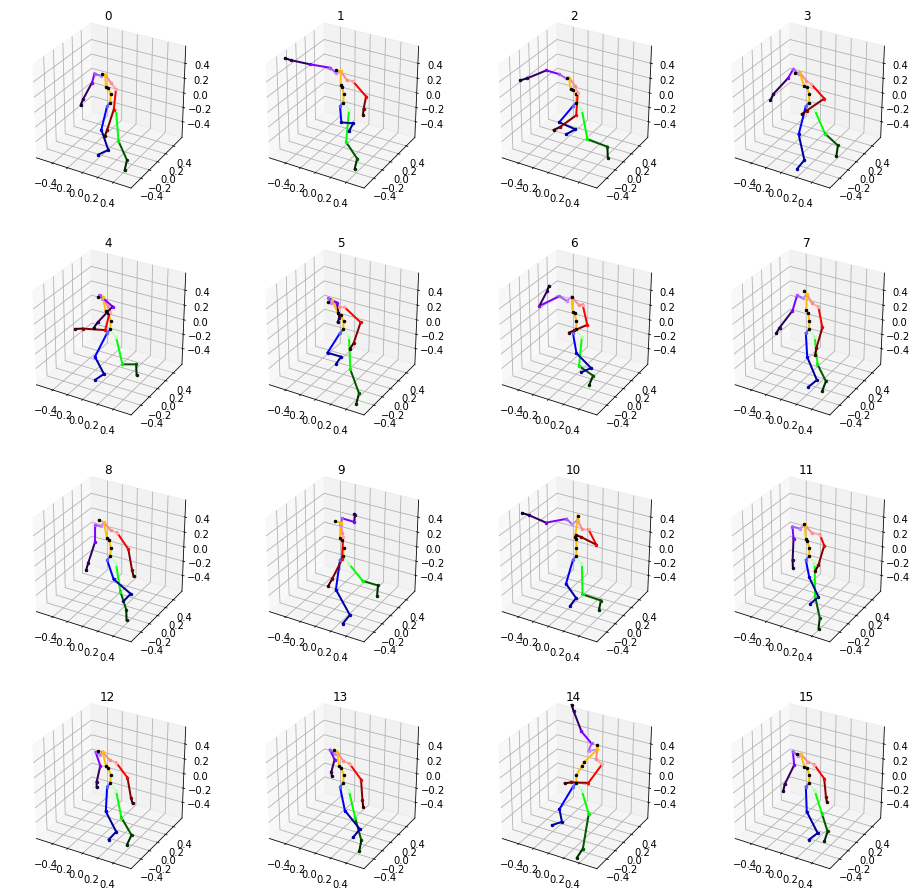

In [13]:
util.sample_random(model, session)

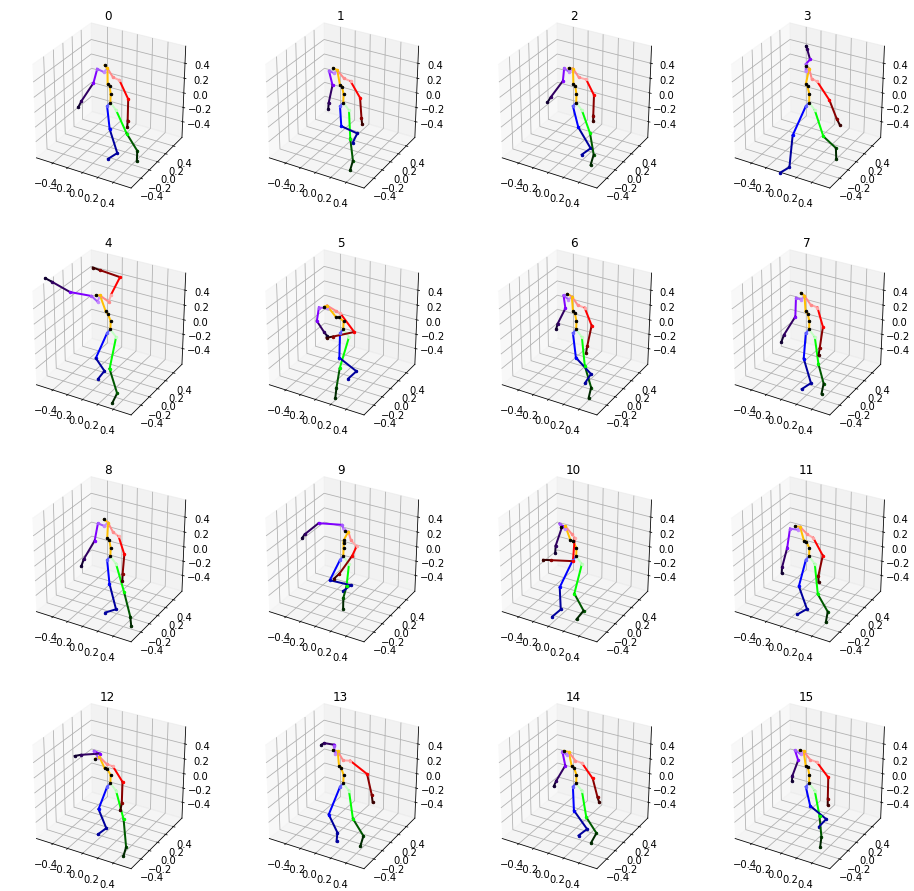

In [14]:
util.sample_random(model, session)

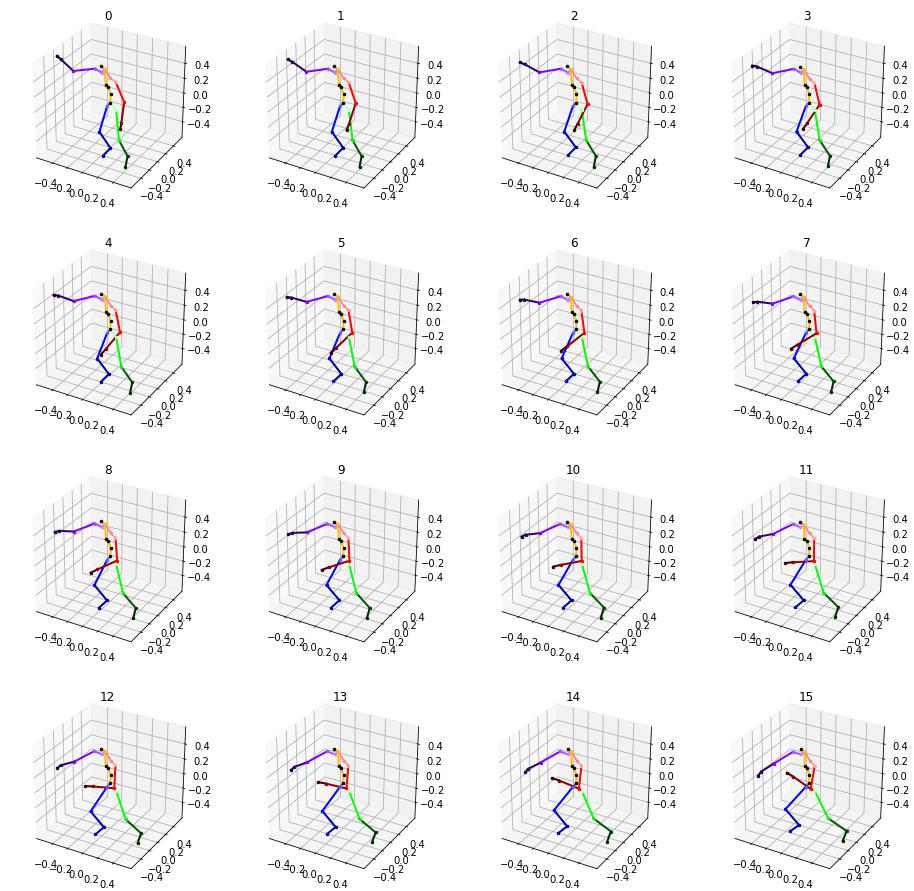

In [15]:
util.grid_interpolate(model, session, theta_emb)

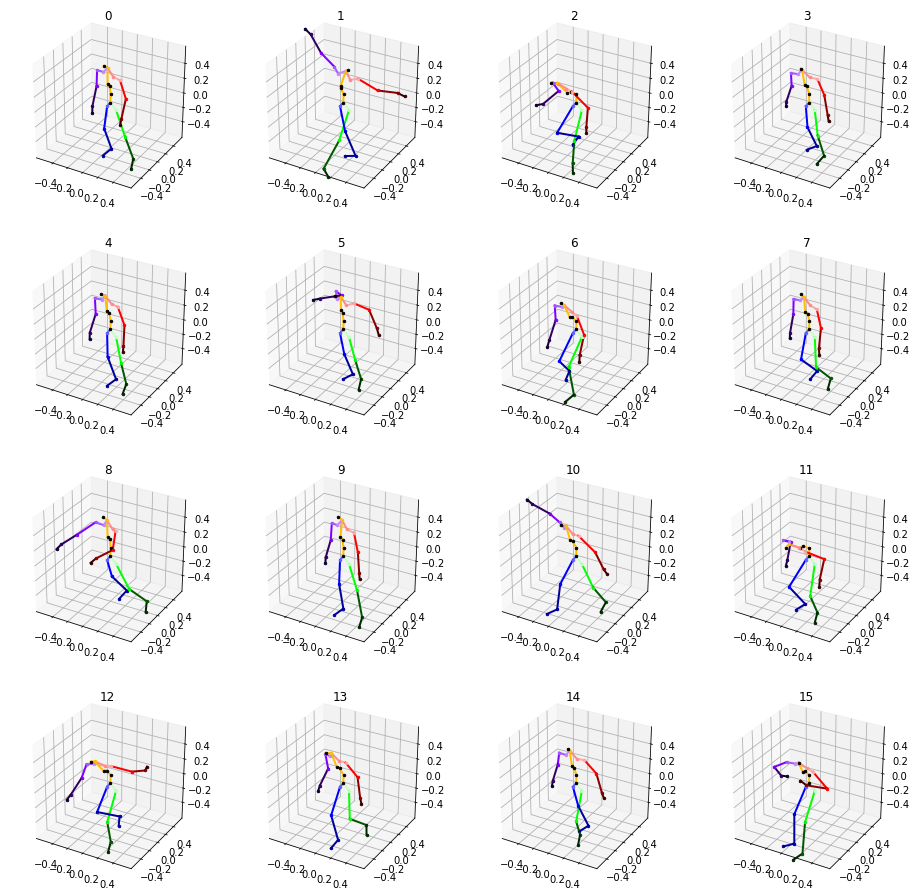

In [16]:
util.get_smpl_j3d(model, session, dataset_theta[idx])

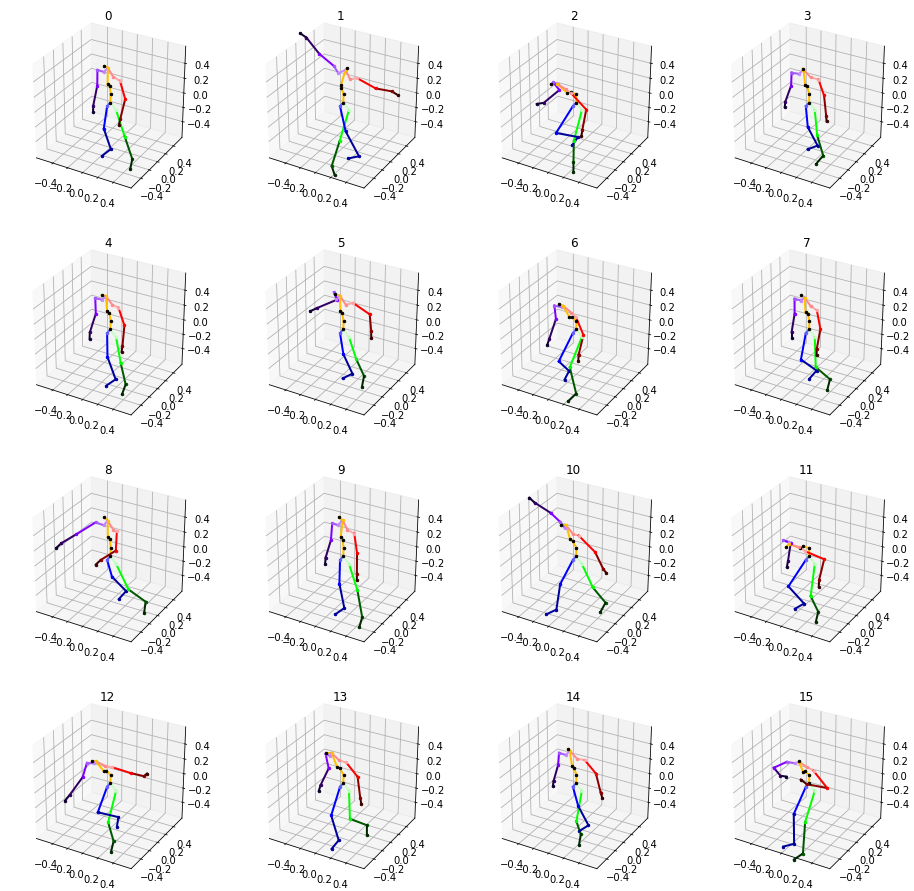

In [17]:
util.get_smpl_j3d(model, session, theta_out_dec)

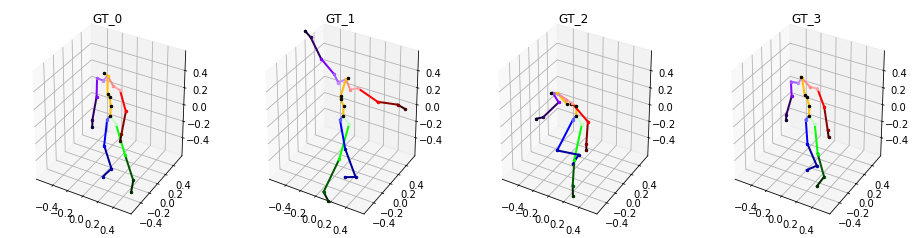

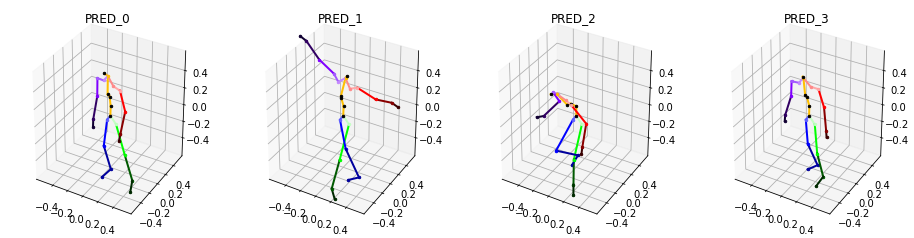

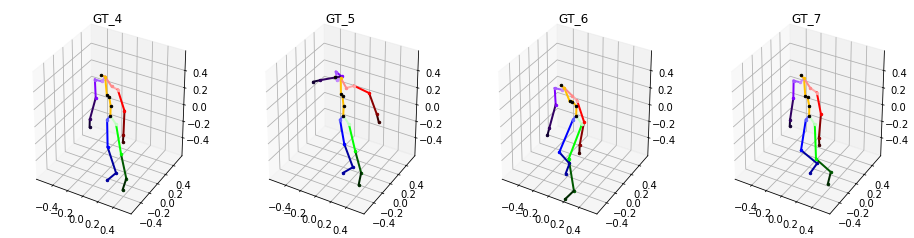

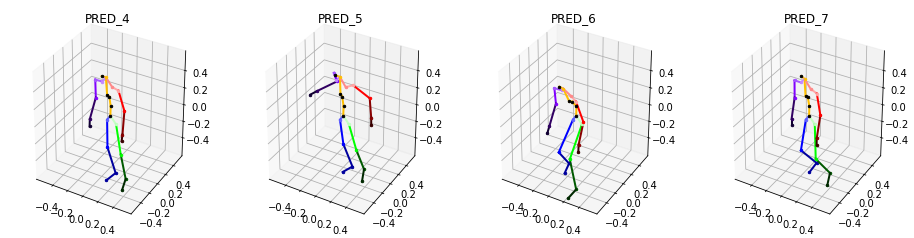

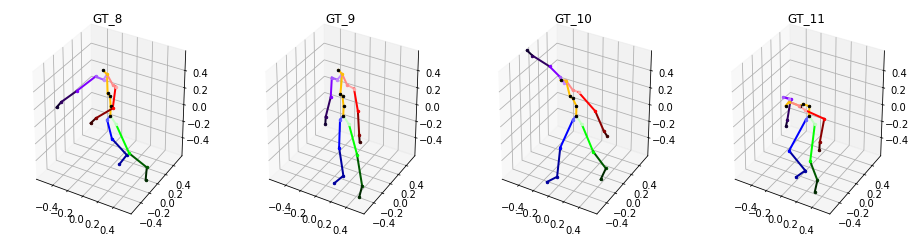

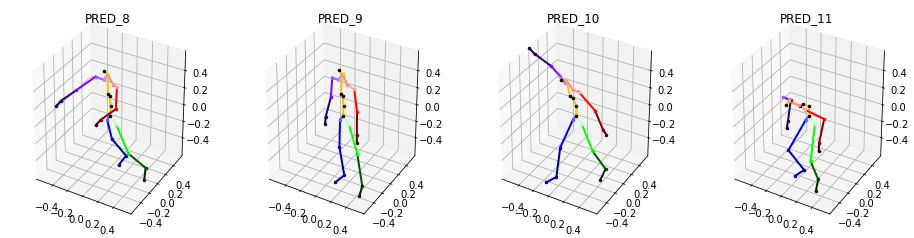

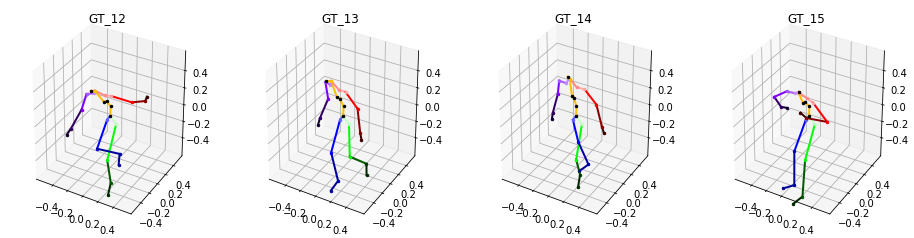

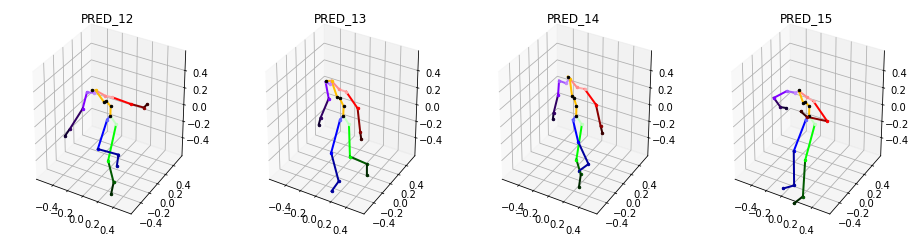

In [18]:
util.vis_recon(model, session, dataset_theta[idx], theta_out_dec)

### Vis mosh pose

In [13]:
# theta_mosh = np.load('/sda5/govind/Mosh/mosh_valid.npy')
# print(theta_mosh.shape)
# theta_mosh = np.reshape(theta_mosh, [-1, 24, 3])
# print(theta_mosh.shape)
dataset_theta.shape

(3943535, 23, 3)

(256, 23, 3, 3)
(256, 24, 3)


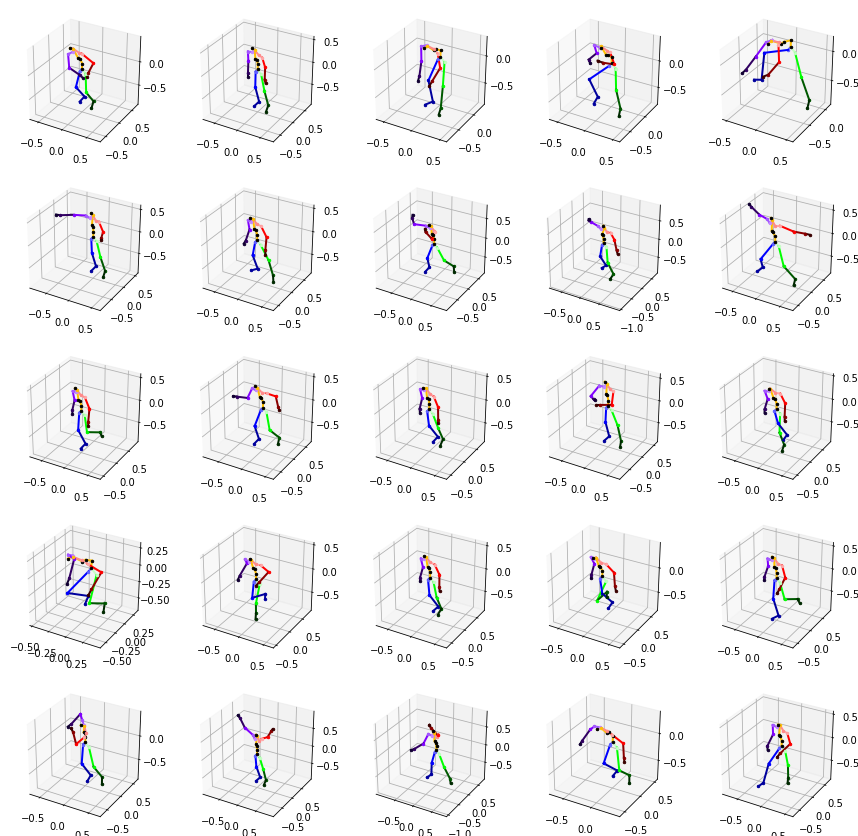

In [15]:
theta_smpl_in = util.rodrigues_repr(dataset_theta[np.random.randint(0, 3943535, 256)])
theta_smpl_in = np.reshape(theta_smpl_in, [-1, 23, 3, 3])
print(theta_smpl_in.shape)
get_smpl_j3d(theta_smpl_in)

(256, 23, 3, 3)
(256, 24, 3)


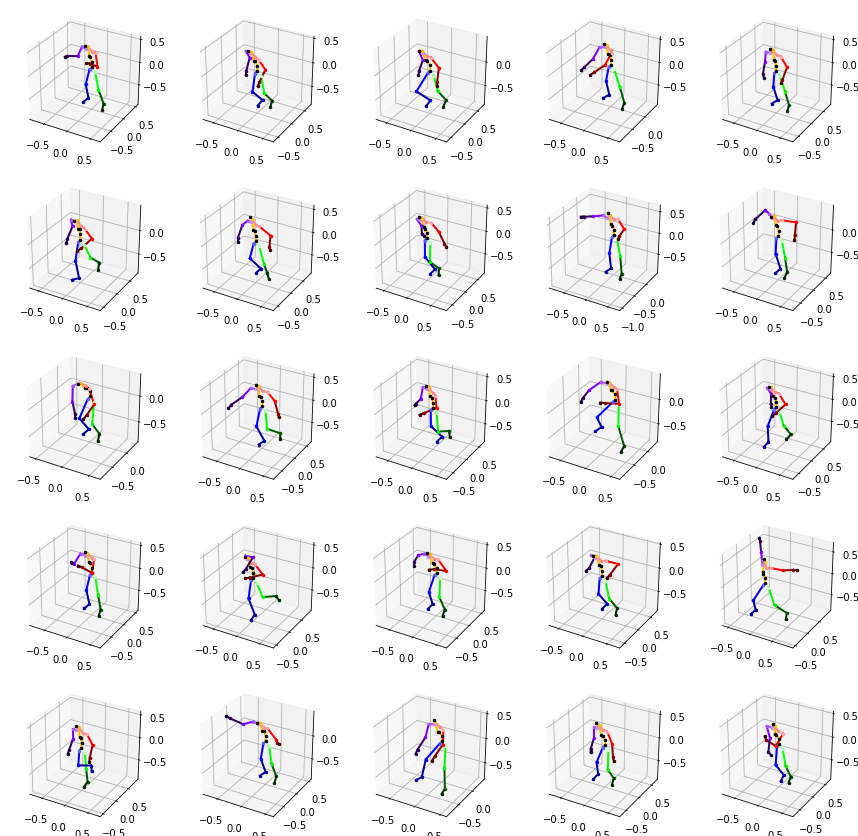

In [19]:
theta_smpl_in = util.rodrigues_repr(dataset_theta[np.random.randint(0, 3943535, 256)])
theta_smpl_in = np.reshape(theta_smpl_in, [-1, 23, 3, 3])
print(theta_smpl_in.shape)
get_smpl_j3d(theta_smpl_in)